# Pendulum with Structured LNN and Control
- We know the data is angle and use it as advantage

## TODO:

- Plot Mass Matrix
- Plot Potential
- Understand the control

In [1]:
import numpy as np
import torch

import sys
import time
sys.path.append("../../")

## Train Model

In [2]:
# hparams
num_sample = 10000
batch_size = 128
portion = 0.5

learning_rate = 3e-4
min_delta = 0
patience = 50

time_horizon = 5
solver = 'rk4'

model_name = 'latent_recon_dimg.pt'
# Check Model params in Model section

### Set Seed Here

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

### Load the data set
- init_condition: list of tuple

 [(x0, p0, t0, t1, steps)]

In [4]:
from gym_env import PendulumCustomEnv
from data import Gym_DataModule_rng

In [5]:
env = PendulumCustomEnv(full_phase=True)
low = np.array([-2])
high = -low

# env, time step, traj, control
dataModule = Gym_DataModule_rng(env,
                                num_sample,
                         
                                low=low,
                                high=high,
                                no_act_portion=portion,
                                time_horizon=time_horizon,
                                batch_size=batch_size,
                                data_dir='../../data/dataset',
                                use_img=True)

dataModule.setup()

In [6]:
print(dataModule.dataset.tensors[0].shape)  # (bs, time, [cos q, sin, q, dq])
print(dataModule.dataset.tensors[1].shape)  # (bs, time, [control])
print(dataModule.dataset.tensors[2].shape)  # (bs, time, [time])
print(dataModule.dataset.tensors[3].shape)  # (bs, time, [th, dth, ddth])
print(dataModule.dataset.tensors[4].shape)  # (bs, time, images)

torch.Size([10000, 5, 3])
torch.Size([10000, 5, 1])
torch.Size([10000, 5, 1])
torch.Size([10000, 5, 3])
torch.Size([10000, 5, 28, 28, 2])


### Define Model

In [7]:
from torchdyn.models import NeuralODE

from module.LNNODE_latent import LNNODE_latent
from nn import MLP, PSD, MatrixNet

In [8]:
massMatrixNet = PSD([2, 64, 64, 1], activation='sigmoid')
potentialNet = MLP([2, 64, 64, 1], activation='sigmoid')
controlNet = MatrixNet([2, 64, 64, 1], control_dim=1, activation='relu')

lagFunc = LNNODE_latent(num_angle=1, 
                        massMatrixNet=massMatrixNet,
                        potentialNet=potentialNet,
                        controlNet=controlNet)

lagODE = NeuralODE(lagFunc, sensitivity='adjoint', solver=solver).to(device)

In [9]:
torch.save(lagODE, 'models/before_{}'.format(model_name))

### Pretrain with time horizon = 2

In [10]:
import torch.nn.functional as F

import pytorch_lightning as pl

from pytorch_lightning.callbacks import EarlyStopping

In [11]:
class Pre_learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss
        self.time_horizon = 2

    def forward(self, x):
        return self.model.defunc(0, x)

    def training_step(self, batch, batch_idx):
        x, u, t, _ = batch
        t_span = t[0, :self.time_horizon, 0]
        q_dq_u = torch.cat([x[:, :self.time_horizon, :], u[:, :self.time_horizon, :]], dim=2)  # Pick (q, dq, u)

        est = self.model.trajectory(q_dq_u[:, 0, :], t_span)

        loss = self.loss_func(q_dq_u, est.transpose(0, 1))
        
        self.logger.experiment.add_scalars("loss", {"train": loss}, self.current_epoch)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=learning_rate)

In [12]:
# pre_Learn = Pre_learner(lagODE)
# pre_trainer = pl.Trainer(max_epochs=10)
# pre_trainer.fit(pre_Learn, dataModule)

### Define Pytorch lightning trainer

In [153]:
class Learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss

        self.kl_coeff = 0.1
        self.log_scale = torch.nn.Parameter(torch.Tensor([0.0]))  # For reconstruction

    def forward(self, x):
        return self.model.defunc(0, x)

    def training_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)

        self.logger.experiment.add_scalars("loss", {"train": loss}, self.current_epoch)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
    
        self.log('val_loss', loss)
        self.logger.experiment.add_scalars("loss", {"val": loss}, self.current_epoch)
        return loss

    def sample(self, mu, log_var):
        std = torch.exp(log_var / 2)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))  # prior
        q = torch.distributions.Normal(mu, std)  # p(z|x)  force the distribution to close to prior
        z = q.rsample()
        return p, q, z

    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3, 4))

    def step(self, batch, batch_idx):
        _, u, t, info, imgs = batch
        t_span = t[0, :, 0]
        bs = imgs.shape[0]
        time_horizon = t.shape[1]

        img_flat = imgs.reshape(bs, time_horizon, -1)

        enc = self.model.defunc.m.encoder(img_flat)
        mu = self.model.defunc.m.fc_mu(enc)
        log_var = self.model.defunc.m.fc_var(enc)
        p, q, z = self.sample(mu, log_var)

        imgs_recon = self.model.defunc.m.decoder(z).reshape(bs, time_horizon, 28, 28, 2)

        recon_loss = self.gaussian_likelihood(imgs_recon, self.log_scale, imgs)

        # drecon_loss = self.loss_func(img_recon[:, :-1, :, :, 0] + img_recon[:, :-1, :, :, 1], img_recon[:, 1:, :, :, 0])

        log_qz = q.log_prob(z)
        log_pz = p.log_prob(z)

        kl = log_qz - log_pz
        kl = kl.sum(dim=(1, 2))

        losses = kl * self.kl_coeff + recon_loss * 1024
        loss = losses.sum()

        logs = {
            "recon_loss": recon_loss,
            "kl": kl,
            "loss": loss,
        }
        return loss, logs

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=learning_rate)

In [154]:
learn = Learner(lagODE)

early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=min_delta, patience=patience)
trainer = pl.Trainer(callbacks=[early_stopping], min_epochs=500, max_epochs=5000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


### Train

In [155]:
start_time = time.time()

In [156]:
trainer.fit(learn, dataModule)


  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 222 K 
------------------------------------
222 K     Trainable params
0         Non-trainable params
222 K     Total params
0.888     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:348: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


AttributeError: 'LNNODE_latent' object has no attribute 'fc_mu'

In [157]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 12.023380994796753 seconds ---


### Save Model
- Pytorch Lightning model check point is buggy
- Use Pytorch save and load method instead

In [18]:
torch.save(lagODE, 'models/{}'.format(model_name))

## Model Analysis

In [19]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

### Load Model

In [20]:
test_model = torch.load('models/{}'.format(model_name))
test_model.eval()

test_model = test_model

### Generate trajectory with Gym Env

In [21]:
# define testing time stamp
dt = 0.05
full = 500
t_span = torch.linspace(dt, dt*full, full)

In [22]:
import cv2
def preproc_pend(img):
    gray = cv2.cvtColor(img[220: 780, 220: 780, :], cv2.COLOR_BGR2GRAY)  # Grey Scale
    img = cv2.resize(gray, [28, 28])  # Rescale image
    img[img == 255] = 0  # Black background (0 seems better for training)
    output = img / 255
    return output

In [87]:
# Generate Trajectory
env.seed(0)
np.random.seed(0)

env = PendulumCustomEnv()
obs = []
infos = []
images = []

# control = 2
# controls = np.random.randint(-2, 2 + 1, full+1)
split = 20
controls = np.random.randint(-2, 2 + 1, int(full / split))
controls = np.repeat(controls, split)
controls = np.zeros_like(controls)

# obs0, _ = env.reset(np.array([3., 1.]))
obs0, _ = env.reset(np.array([np.pi / 4, 0.]))

prev_obs = obs0
prev_img = env.render('rgb_array')

for i in range(full):
    obs.append(prev_obs)
    images.append(preproc_pend(prev_img))
    
    next_obs, reward, done, info = env.step(controls[i])
    next_img = env.render('rgb_array')
    
    infos.append(np.array([info['th'], info['dth'], info['ddth']]))
    
    prev_obs = next_obs
    prev_img = next_img

obs = torch.tensor(obs)
infos = torch.tensor(infos)
imgs = torch.tensor(images)
controls = torch.Tensor(controls).view(-1, 1)
env.close()

### Generate Prediction

In [88]:
P = imgs[1:, :, :]
dP = imgs[1:, :, :] -imgs[: -1, :, :]
P_dP = torch.stack([P, dP], dim=3)

In [89]:
P_dP.view(1, 499, -1).shape

torch.Size([1, 499, 1568])

In [90]:
z = test_model.defunc.m.encoder(P_dP.reshape(1, 499, -1).float())

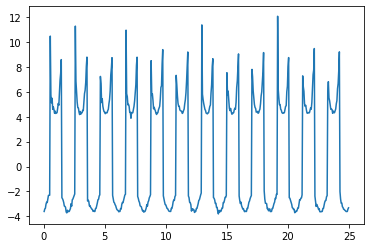

In [147]:
plt.plot(t_span[:499].detach().numpy(), z[0, :, 1].detach().numpy())
# plt.ylim(-4, 4)

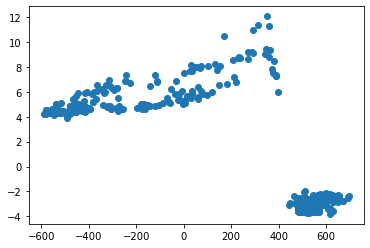

In [152]:
plt.scatter(z[0, :, 0].detach().numpy(), z[0, :, 1].detach().numpy())
# plt.xlim(-0.1, 0.1)

In [93]:
from utils import traj_pred

# Generate prediction

q_dq_u = torch.stack([torch.cos(z[0, :, 0]), torch.cos(z[0, :, 0]), z[0, :, 1], controls[1:, 0]], dim=1)
q_dq = torch.stack([torch.cos(z[0, :, 0]), torch.cos(z[0, :, 0]), z[0, :, 1]], dim=1)
est_grad = test_model.defunc(0, q_dq_u.float())
est_z = traj_pred(0.05, test_model, q_dq[0, :].detach().numpy(), controls)

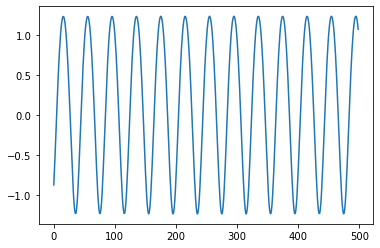

In [94]:
plt.plot(est_z.y[1, :])

In [108]:
est_z2 = torch.tensor(est_z.y.T)

In [117]:
angle = torch.atan(est_z2[:, 1] / est_z2[:, 0])

In [97]:
est_z2 = torch.stack([angle, est_z2[:, 2]], dim=1)

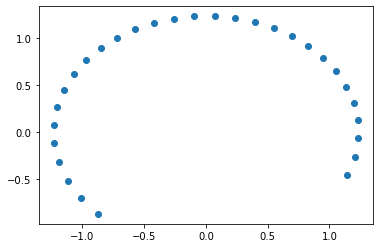

In [120]:
plt.scatter(est_z2[:30, 0], est_z2[:30, 1])

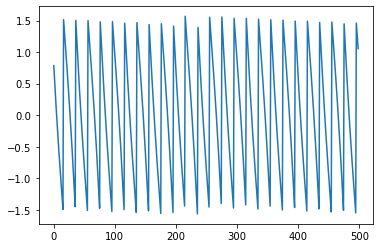

In [144]:
plt.plot(angle)

In [138]:
z[0, 0, :]

tensor([481.1737,  -3.6039], grad_fn=<SliceBackward>)

<ipython-input-146-20bf3e6d1c64>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


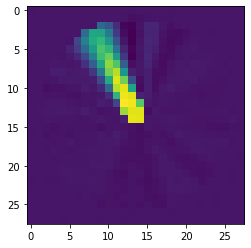

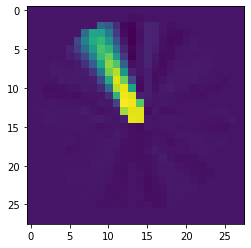

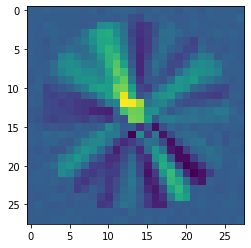

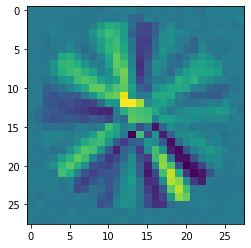

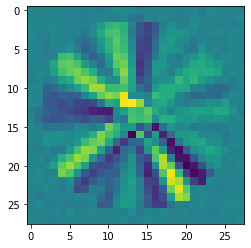

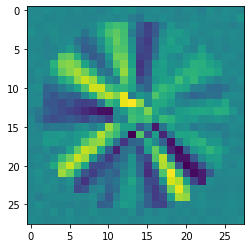

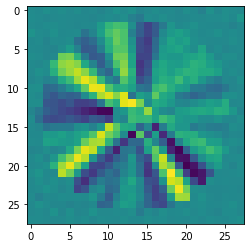

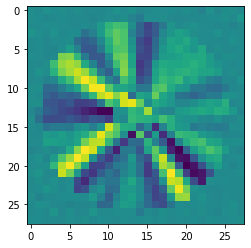

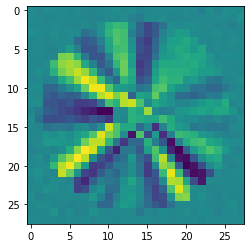

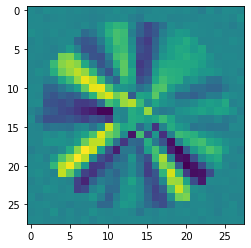

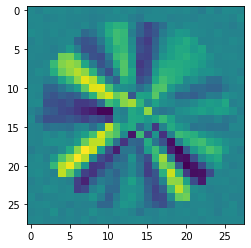

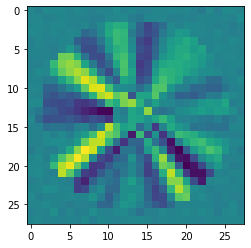

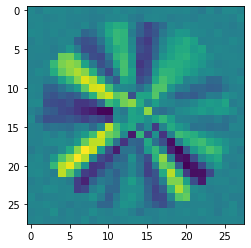

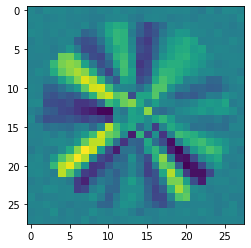

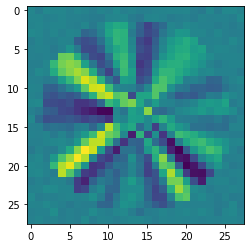

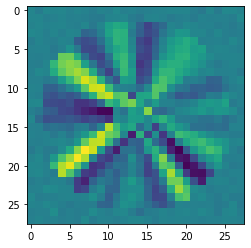

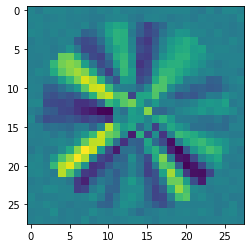

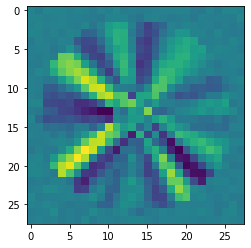

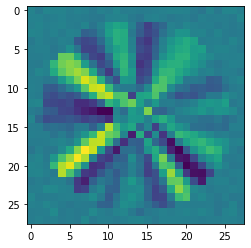

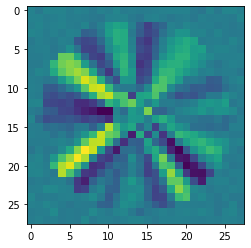

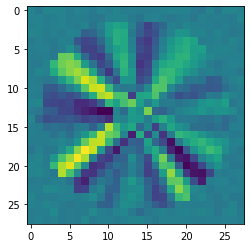

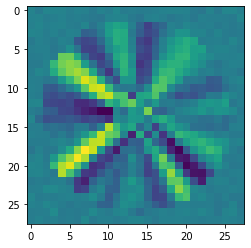

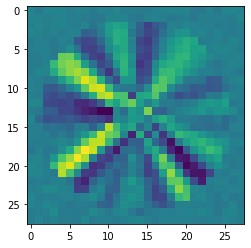

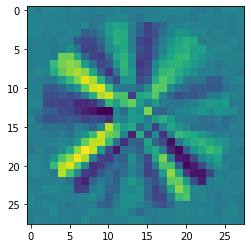

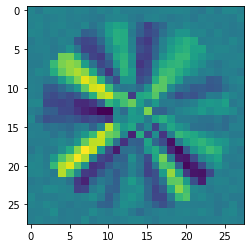

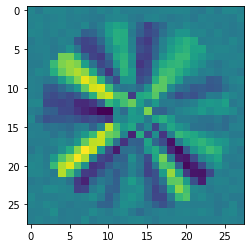

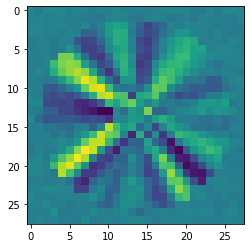

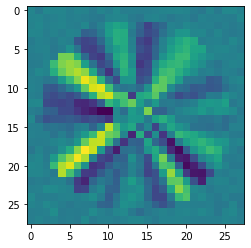

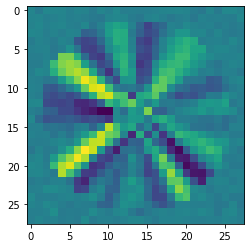

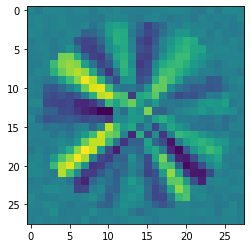

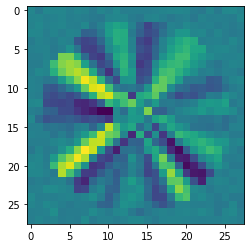

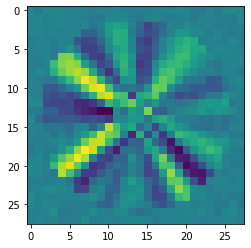

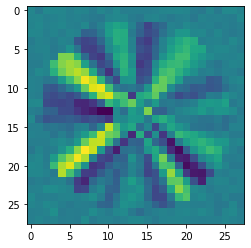

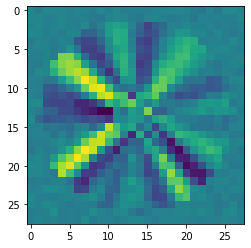

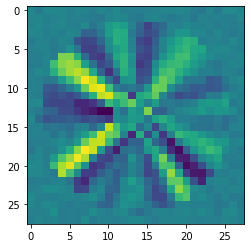

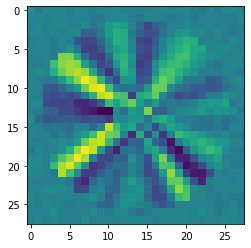

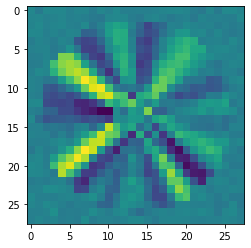

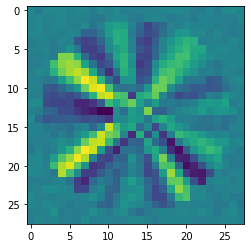

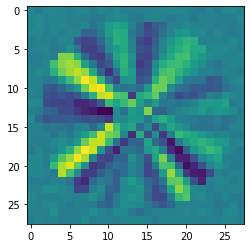

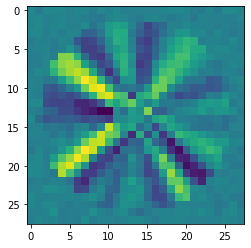

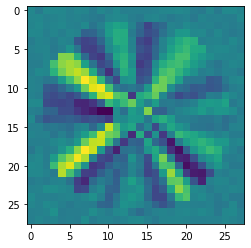

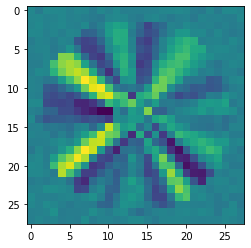

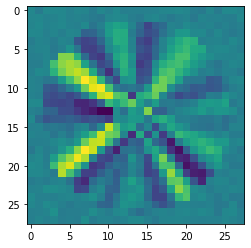

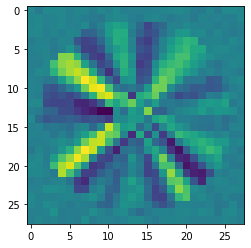

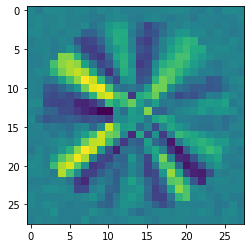

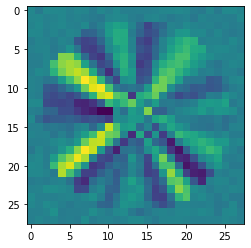

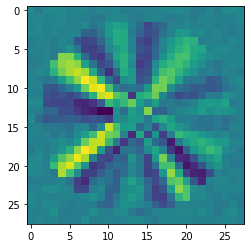

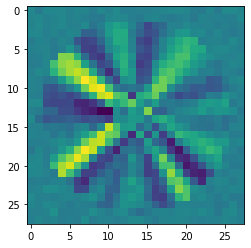

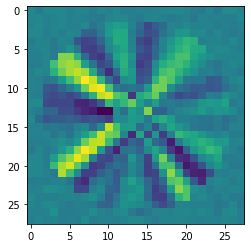

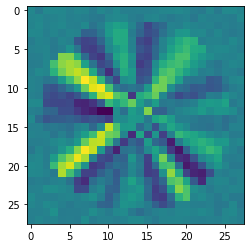

In [146]:
for i in range(50):
    test_img = test_model.defunc.m.decoder(torch.tensor([i * 2., 1.])).reshape(1, 28, 28, 2)
    plt.figure()
    plt.imshow(test_img[0, :, :, 0].detach().numpy())

In [100]:
recon_img = test_model.defunc.m.decoder(est_z2.float())
# recon_img = test_model.defunc.m.decoder(z.float())

In [101]:
recon_img = recon_img.reshape(499, 28, 28, 2)

In [ ]:
num_iters = 50

for i in range(num_iters):
    plt.figure()
    plt.imshow(recon_img[i, :, :, 0].detach().numpy())

In [103]:
from scipy.integrate import solve_ivp

def dummy(t, y):
    idx = int(torch.tensor(t) / dt)
    dx1 = np.multiply(-y[1], y[2])
    dx2 = np.multiply(y[0], y[2])
    ddq = -10 * y[0] + controls[idx-1] / 2.
    return [dx1, dx2, ddq]

sol = solve_ivp(dummy, [dt, dt*full], obs0, method='Radau', t_eval=t_span.detach().numpy())

In [104]:
print(sol.y.shape)
print(obs0)
# sol.t

(3, 500)
[ 0.70710678 -0.70710678  0.        ]


### Check gradient

ValueError: x and y must have same first dimension, but have shapes (500,) and (499,)

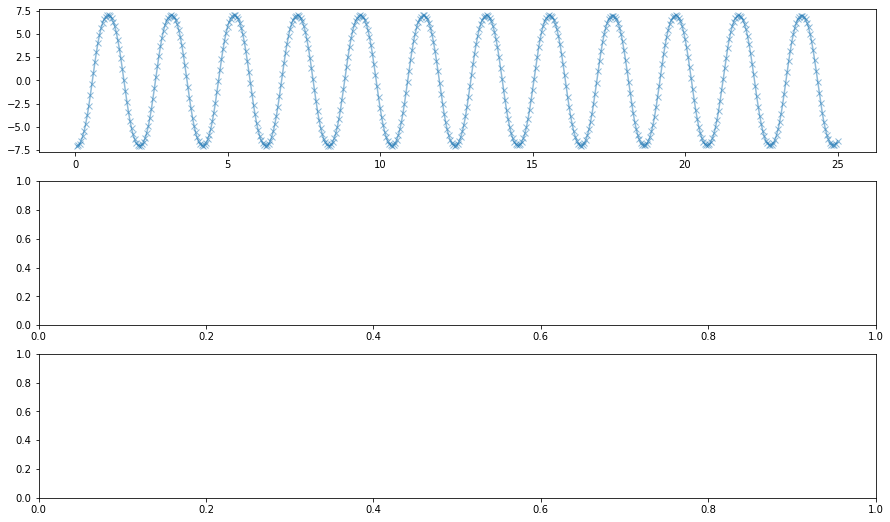

In [105]:
fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

start = 0
end = 500

# Check ddq_est
ax1.plot(t_span.detach().numpy()[start:end], infos[start:end, 2],'x-', alpha=0.5)  # Ground truth
ax1.plot(t_span.detach().numpy()[start:end], est_grad[start:end, 2].detach().numpy(), '--')  # LNN

# check dq_est
ax2.plot(t_span.detach().numpy()[start:end], infos[start:end, 1],'-', alpha=0.5)
ax2.plot(t_span.detach().numpy()[start:end], est.y[2, start:end], '--')  # LNN
# ax2.plot(sol.t[start:end], sol.y[2, start:end])

# Plot control for reference
ax3.plot(t_span.detach().numpy()[start:end], controls[start:end],'x')
# None

### Check trajectory

In [ ]:
# Check trajectory
start = 0
end = 100

fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Plot cos q = x
ax1.plot(t_span.detach().numpy()[start:end], obs[start:end, 0].detach().numpy(), alpha=0.5)
ax1.plot(t_span.detach().numpy()[start:end], est.y[0, start:end], '--')
ax1.plot(sol.t[start:end], sol.y[0, start:end])

# Plot sin q = y
ax2.plot(t_span.detach().numpy()[start:end], obs[start:end, 1].detach().numpy(), alpha=0.5)
ax2.plot(t_span.detach().numpy()[start:end], est.y[1, start:end], '--')
ax2.plot(sol.t[start:end], sol.y[1, start:end])


# Plot control for reference
ax3.plot(t_span.detach().numpy()[start:end], controls[start+1:end+1])
# None
None

### Plot Phase Space Trajectory

In [ ]:
length = 100
# Plot Phase Space traj
th = torch.atan(obs[:length, 1] / obs[:length, 0])
thdot = obs[:length, 2]

est_th = torch.atan(torch.tensor(est.y[1, :length] / est.y[0, :length]))
est_thdot = est.y[2, :length]

fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(th, thdot)
plt.scatter(est_th, est_thdot)

ax.set_xlabel("q")
ax.set_ylabel("dq")
ax.set_title("Phase Diagram")
None

### Plot Mass Matrix

In [ ]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)

M_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
    M_est[i] = test_model.defunc.m.massMatrixNet(q.view(1, -1)).detach().cpu()[0, 0, 0]

    
M_true = torch.ones(M_est.shape)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), M_est, '--', label='M_est')
ax.plot(x.detach().numpy(), M_true, label='M_true', alpha=0.5)

ax.legend()
# ax.set_ylim([0, 1.1])
ax.set_xlabel("q")
ax.set_ylabel("M(q)")
ax.set_title("Mass Matrix")
None

### Plot Potential

In [ ]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)

V_true = 1. * 10 * torch.sin(x)

V_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
    V_est[i] = test_model.defunc.m.potentialNet(q.view(1, -1)).detach().cpu()

V_est = V_est - min(V_est)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), V_est, '--', label='V_est')
ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("V(q)")
ax.set_title("Potential")
None

### Plot Control

In [ ]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)
x1, x2 = torch.meshgrid(x, x)  # (cos q, sin q)

Control = 1. * 10 * torch.ones_like(x)

V_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
    V_est[i] = test_model.defunc.m.controlNet(q.view(1, -1)).detach().cpu()

V_est = V_est - min(V_est)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), V_est, '--', label='Control_est')
# ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("g(q)")
ax.set_title("Control")
None

## Conclusion